# Spacy classifier
Data used: "amazon-fine-food-reviews.zip" on kaggle.

## Download dataset to dataFrame

In [ ]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py


--2022-05-12 00:20:10--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py.2’

explacy.py.2        100%[===================>]   6.73K  --.-KB/s    in 0s      

2022-05-12 00:20:10 (95.0 MB/s) - ‘explacy.py.2’ saved [6896/6896]



We upload our kaggle key generated from "account" in kaggle in order to download the dataset.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace hashes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [ ]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
food_reviews_df = pd.read_csv('Reviews.csv')
print(f'''
    rows: {food_reviews_df.shape[0]}
    columns: {food_reviews_df.shape[1]}
    ''')


    rows: 568454
    columns: 10
    


In [ ]:
food_reviews_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
ProductId,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K
UserId,A3SGXH7AUHU8GW,A1D87F6ZCVE5NK,ABXLMWJIXXAIN,A395BORC6FGVXV,A1UQRSCLF8GW1T
ProfileName,delmartian,dll pa,"Natalia Corres ""Natalia Corres""",Karl,"Michael D. Bigham ""M. Wassir"""
HelpfulnessNumerator,1,0,1,3,0
HelpfulnessDenominator,1,0,1,3,0
Score,5,1,4,2,5
Time,1303862400,1346976000,1219017600,1307923200,1350777600
Summary,Good Quality Dog Food,Not as Advertised,"""Delight"" says it all",Cough Medicine,Great taffy
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...


## Data raw formating

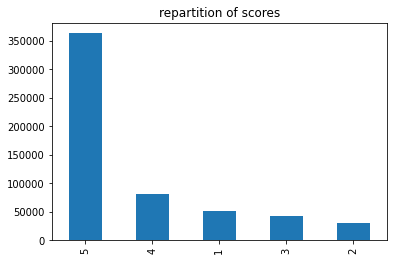

In [ ]:
scored_reviews_df = food_reviews_df[['Text','Score']].dropna()

ax = scored_reviews_df.Score.value_counts().plot(kind="bar", title="repartition of scores")
fig = ax.get_figure()

Due to score inbalance, we modify our score column.

In [ ]:
scored_reviews_df.Score[food_reviews_df.Score<=3]=0
scored_reviews_df.Score[food_reviews_df.Score>=4]=1
scored_reviews_df.rename(columns={"Score": "is_positive"}, inplace=True)
scored_reviews_df.head().T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...
is_positive,1,0,1,0,1


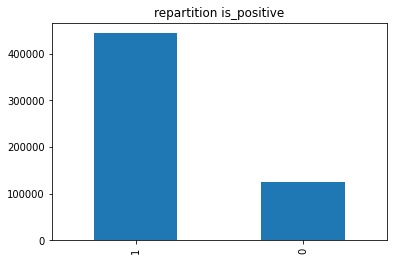

In [ ]:
ax = scored_reviews_df.is_positive.value_counts().plot(kind="bar", title="repartition is_positive")
fig = ax.get_figure()

We get rid of rows to avoid crash on colab kernel. We also choose same number of both score value.

In [ ]:
train_pos_df = scored_reviews_df[scored_reviews_df.is_positive==1][:50000]
train_neg_df = scored_reviews_df[scored_reviews_df.is_positive==0][:50000]
train_df = train_pos_df.append(train_neg_df)
print(f'''
    rows: {train_df.shape[0]}
    columns: {train_df.shape[1]}
''')


    rows: 100000
    columns: 2



## Tokenisation

Tokenization means splittig text into small pieces of word, punctuation...  
We'll use a tokenizer from spacy.

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy validate

     |████████████████████████████████| 12.8 MB 5.0 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.3.0) =================
ℹ spaCy installation: /usr/local/lib/python3.7/dist-packages/spacy

NAME             SPACY                 VERSION                            
en_core_web_sm   >=3.3.0.dev0,<3.4.0   3.3.0   ✔



In [ ]:
spacy_tok = spacy.load('en_core_web_sm')  # english core web small
sample_review=food_reviews_df.Text[30]
sample_review

"I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)"

In [ ]:
import explacy

parsed_review = spacy_tok(sample_review)
parsed_review
explacy.print_parse_info(spacy_tok, 'The salad was surprisingly tasty.')

Dep tree Token        Dep type Lemma        Part of Sp
──────── ──────────── ──────── ──────────── ──────────
    ┌─►  The          det      the          DET       
 ┌─►└──  salad        nsubj    salad        NOUN      
┌┼─────  was          ROOT     be           AUX       
││  ┌─►  surprisingly advmod   surprisingly ADV       
│└─►└──  tasty        acomp    tasty        ADJ       
└─────►  .            punct    .            PUNCT     


In [ ]:
explacy.print_parse_info(spacy_tok,food_reviews_df.Text[30])


Dep tree                      Token         Dep type  Lemma         Part of Sp
───────────────────────────── ───────────── ───────── ───────────── ──────────
                        ┌───► I             nsubj     I             PRON      
                        │┌──► have          aux       have          AUX       
                        ││┌─► never         neg       never         ADV       
                    ┌┬──┴┴┴── been          ROOT      be            AUX       
                    ││  ┌───► a             det       a             DET       
                    ││  │┌──► huge          amod      huge          ADJ       
                    ││  ││┌─► coffee        compound  coffee        NOUN      
                    │└─►└┴┴── fan           attr      fan           NOUN      
                    └───────► .             punct     .             PUNCT     
                     ┌──────► However       advmod    however       ADV       
                     │┌─────► ,             punct   

## Lemmatization

Le lemme est une opération linguistique https://fr.wikipedia.org/wiki/Lemme_(linguistique).  
`It is the process of extracting uninflected/base form of the word. Lemma can be like For eg.   
Adjectives: best, better → good Adverbs: worse, worst → badly Nouns: ducks, children → duck, child Verbs: standing,stood → stand`  

Besoin d'approfondire ces indicateurs. 

In [ ]:
tokenized_text = pd.DataFrame()

# enumerate add an index to the iterators

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:10]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,I,PRON,PRP,nsubj,X,True,True,False
1,have,"(have,)",AUX,VBP,aux,xxxx,True,True,False
2,never,"(never,)",ADV,RB,neg,xxxx,True,True,False
3,been,"(be,)",AUX,VBN,ROOT,xxxx,True,True,False
4,a,"(a,)",DET,DT,det,x,True,True,False
5,huge,"(huge,)",ADJ,JJ,amod,xxxx,True,False,False
6,coffee,"(coffee,)",NOUN,NN,compound,xxxx,True,False,False
7,fan,"(fan,)",NOUN,NN,attr,xxx,True,False,False
8,.,"(.,)",PUNCT,.,punct,.,False,False,True
9,However,"(however,)",ADV,RB,advmod,Xxxxx,True,True,False


##Named Entity Recognition (NER)¶

> Bloc en retrait



Spacy figures out automatically which word corresponds to which named entity.

Type	  | Description
-------------------|------------------
PERSON       | People, including fictional.
NORP     |Nationalities or religious or political groups.
FAC     |Buildings, airports, highways, bridges, etc.
ORG     |Companies, agencies, institutions, etc.
GPE     |Nationalities or religious or political groups.
...



In [ ]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)


In [ ]:
spacy.explain('GPE') # to explain type

'Countries, cities, states'

##Dependency parsing
```
Syntactic Parsing or Dependency Parsing is process of identifyig sentenses  
and assigning a syntactic structure to it.  
As in Subject combined with object makes a sentence.  
Spacy provides parse tree which can be used to generate this structure.`
```
__Sentense Boundry Detection__
```
Figuring out where sentense starts and ends is very imporatnt part of nlp.
```



In [ ]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[I have never been a huge coffee fan.,
 However, my mother purchased this little machine and talked me into trying the Latte Macciato.,
 No Coffee Shop has a better one,
 and I like most of the other products, too (as a usually non-coffee drinker!).<br />The,
 little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up).,
 I would recommend the Dolce Gusto to anyone.,
 Too good for the price and I'am getting one myself!,
 :)]

In [ ]:
displacy.render(parsed_review, style='dep', jupyter=True,options={'distance': 140})

play with colors opts

In [ ]:

options = {'compact': True, 'bg': 'yellow','distance': 140,
           'color': 'red', 'font': 'Trebuchet MS'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

In [ ]:
spacy.explain("ADJ") ,spacy.explain("det") ,spacy.explain("ADP") ,spacy.explain("prep")  # to understand tags


('adjective', 'determiner', 'adposition', 'prepositional modifier')

 ## Nouns


In [ ]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,I,I,I,nsubj,been
1,a huge coffee fan,"(fan,)","(fan,)",attr,been
2,my mother,"(mother,)","(mother,)",nsubj,purchased
3,this little machine,"(machine,)","(machine,)",dobj,purchased
4,me,"(me,)","(me,)",dobj,talked
5,the Latte Macciato,"(Macciato,)","(Macciato,)",dobj,trying
6,No Coffee Shop,"(Shop,)","(Shop,)",nsubj,has
7,I,"(I,)","(I,)",nsubj,like
8,the other products,"(products,)","(products,)",pobj,of
9,a usually non-coffee drinker!).<br,"(drinker!).<br,)","(drinker!).<br,)",pobj,as


Word vectors and similarity

```
Sence2vec
The idea is get something better than word2vec model.

The idea behind sense2vec is super simple. If the problem is that duck as in waterfowl and duck as in crouch are different concepts, the straight-forward solution is to just have two entries, duckN and duckV. Trask et al (2015) published a nice set of experiments showing that the idea worked well.

It assight parts of speech tags like verb, noun , adjective to words, which will in turn be used to make sence of context.

Please book [VERB] my ticket.
Read the book [NOUN].
Read more here and here

Reddit talks about food a lot so we can get nice similarity vectors for food items.
```

In [ ]:
!pip install sense2vec

In [ ]:
# merite de brûler en enfer
import sense2vec
from sense2vec import Sense2VecComponent

s2v = Sense2VecComponent('../input/reddit-vectors-for-sense2vec-spacy/reddit_vectors-1.1.0/reddit_vectors-1.1.0/')
spacy_tok.add_pipe(s2v)
doc = spacy_tok(u"dessert.")
freq = doc[0]._.s2v_freq
vector = doc[0]._.s2v_vec
most_similar = doc[0]._.s2v_most_similar(5)
most_similar,freq

## Text classifier

We'll use the TextCategorizer from spacy which base infrastructure is a CNN.
```
The document tensor is then summarized by concatenating max and mean pooling, and a multilayer perceptron is used to predict an output vector of length nr_class, before a logistic activation is applied elementwise. The value of each output neuron is the probability that some class is present.
```

In [ ]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['is_positive']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  1)]

# ⚠️ TODO - REVIEW THIS

In [ ]:
#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [ ]:
nlp = spacy.load('en_core_web_sm')  # create english Language class


# ⚠️ see add_pipe evolution spacy or downgrade

In [ ]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

ValueError: ignored